# Topic Modeling: ADHD

### The first step is importing the packages that we will be using for identifying topic models.

In [1]:
# Import required packages

# DATA PREPROCESSING
import nltk
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from gensim.models import Phrases

# MODELING
import sklearn
import re
from gensim.models.coherencemodel import CoherenceModel
from gensim.models.ldamodel import LdaModel
from gensim.corpora.dictionary import Dictionary
from numpy import array

# VISUALIZATION
import matplotlib.pyplot as plt
import seaborn as sns
import pyLDAvis
import pyLDAvis.gensim
import pickle 

# OTHER
import numpy as np
import pandas as pd
import logging
import json
import warnings
import random

warnings.filterwarnings('ignore')  

### In the second step, we read the dataset, and take a glance at what it looks like.

In [2]:
data = pd.read_csv('adhd.csv')

In [3]:
data.head()

,user_ID,followers_count,user_location,user_description,date,text,hashtags
0,1.365320e+18,52,"Sheffield, England","❤Sal / UK\r\r\n🧡Player of games, Master of non...",10/27/2021 12:40,Saw GP today and we went through stuff and I t...,NaN
1,5.363879e+07,1667,UK,27y/o nonbinary creator. They/Them. disabled. ...,10/27/2021 12:40,My ADHD Graveyard | Officially Diagnosed and A...,NaN
2,1.329360e+18,12,"England, United Kingdom",38. A diagnosis referral is hard in the UK. Se...,10/27/2021 12:37,Have there been any studies of adults or child...,"['askADHD', 'ADHD']"
3,1.242600e+18,8,"West Hempstead, NY",OrganizeU4Life is making an impact on the live...,10/27/2021 12:35,Environmental factors don’t directly cause ADH...,NaN
4,1.429030e+18,48,España,"🔞. Mainly NSFW. He/Him. 28. Gay, Single and Lo...",10/27/2021 12:33,Here in Spain we celebrate the national day of...,['ADHD']


### Then, we extract our column of interest, which is the tweet.

In [4]:
tweets = data['text']

### Once we have the tweets, we pre-process the data to make it ready for analysis.

Initially, we convert everything to lowercase, and then we remove users, links, punctuation, double spaces, numbers, short words, emojis and stopwords.

Then, we tokenize each word, splitting the sentences in separate words.

Lasly, we convert each word into their lemmas (the form of a word under which it is registered in a dictionary).

In [5]:
# list of commonly repeated words that do not add meanings
my_stopwords = nltk.corpus.stopwords.words('english')
repeated_words = ['ever', 'start', 'pre', '&amp', 
                  'amp', 'may', 'and', 'when',
                  'what','who', 'why','how', 
                  'this', 'your', 'mine', 'their',
                  'her', 'his', 'that', 'mental']

for i in repeated_words:
    my_stopwords.append(i)
    
tweets = tweets.apply(lambda x: ' '.join([word for word in x.split() if word not in (my_stopwords)]))
tweets = array(tweets)
    
# list of common punctuation    
my_punctuation = '!"$%&\'()*+,-./:;<=>?[\\]^_`’{|}~•@'

# list of the majority of emojis
emoj = re.compile("["  
    u"\U0001F600-\U0001F64F" 
    u"\U0001F300-\U0001F5FF" 
    u"\U0001F680-\U0001F6FF"  
    u"\U0001F1E0-\U0001F1FF"  
    u"\U00002500-\U00002BEF"  
    u"\U00002702-\U000027B0"
    u"\U00002702-\U000027B0"
    u"\U000024C2-\U0001F251"
    u"\U0001f926-\U0001f937"
    u"\U00010000-\U0010ffff"
    u"\u2640-\u2642" 
    u"\u2600-\u2B55"
    u"\u200d"
    u"\u23cf"
    u"\u23e9"
    u"\u231a"
    u"\ufe0f"  
    u"\u3030"
                  "]+", re.UNICODE) 

In [6]:
def preprocessor(tweets):
    """
    Removes unnecessary information from tweets,
    and lemmatizes the tweets.

    Input(s):
    ------------------------------
    tweets(array): all original tweets
    
    Output(s):
    ------------------------------
    tweets(array): cleaned up and lemmatized tweets
    """
    tokenizer = RegexpTokenizer(r'\w+')
    for idx in range(len(tweets)):       
        tweets[idx] = re.sub(r'http\S+', '', tweets[idx]) # http links
        tweets[idx] = re.sub(r'bit.ly/\S+', '', tweets[idx]) # bitly links
        tweets[idx] = tweets[idx].strip('[link]') # other links(i.e. gifs)
        tweets[idx] = tweets[idx].lower()  # turn to lowercase
        tweets[idx] = re.sub('(RT\s@[A-Za-z]+[A-Za-z0-9-_]+)', '', tweets[idx]) # retweets
        tweets[idx] = re.sub('(@[A-Za-z]+[A-Za-z0-9-_]+)', '', tweets[idx]) # tweeted at
        tweets[idx] = re.sub ('#', '', tweets[idx]) # hashtags
        tweets[idx] = re.sub(emoj, '', tweets[idx]) # emojis
        tweets[idx] = re.sub('['+my_punctuation + ']+', ' ', tweets[idx]) # remove punctuation
        tweets[idx] = re.sub('\s+', ' ', tweets[idx]) # remove double spacing
        tweets[idx] = tokenizer.tokenize(tweets[idx])   # split into words


    # numbers (but not words with number)
    tweets = [[token for token in tweet if not token.isdigit()] for tweet in tweets]
    
    # words that are only one character
    tweets = [[token for token in tweet if len(token) > 3] for tweet in tweets]
    
    tweets = [[token for token in tweet if len(token) > 3] for tweet in tweets]
    
    # lemmatize all words in documents
    lemmatizer = WordNetLemmatizer()
    tweets = [[lemmatizer.lemmatize(token) for token in tweet] for tweet in tweets]
 
    return tweets

In [7]:
tweets = preprocessor(tweets)

### We also create bi- and trigrams, and remove words that appear rarely. This is words that occurr frequently together, for example "more_than, less_than".

In [8]:
# add bigrams and trigrams to docs

# only add bi/trigrams that appear > 10 times
bigram = Phrases(tweets, min_count=10)
trigram = Phrases(bigram[tweets])

for idx in range(len(tweets)):
    for token in bigram[tweets[idx]]:
        if '_' in token:
            tweets[idx].append(token)
    for token in trigram[tweets[idx]]:
        if '_' in token:
            tweets[idx].append(token)

dictionary = Dictionary(tweets)
dictionary.filter_extremes(no_below=10, no_above=0.2)

corpus = [dictionary.doc2bow(t) for t in tweets]

### After being ready for analysis, we analyze this data with Latent Dirichlet Allocation model by assigning a random number of topics.

In [9]:
num_topics = 5 # number of topics

temp = dictionary[0] 
id2word = dictionary.id2token

lda_model = LdaModel(corpus=corpus, id2word=id2word, chunksize=len(data)/5, \
                       alpha='auto', eta='auto', \
                       iterations=20, num_topics=num_topics, \
                       passes=20, eval_every=1)

# show keywords
print(lda_model.print_topics())

[(0, '0.078*"what" + 0.076*"change_knew" + 0.052*"would" + 0.051*"find_started" + 0.051*"asking_question" + 0.051*"exercise_nutrition" + 0.051*"important_sleep" + 0.026*"sleep" + 0.026*"question" + 0.026*"habit"'), (1, '0.015*"adhdawarenessmonth" + 0.012*"autism" + 0.011*"like" + 0.009*"anxiety" + 0.009*"people" + 0.008*"help" + 0.008*"mentalhealth" + 0.008*"time" + 0.008*"child" + 0.008*"thing"'), (2, '0.016*"think_might" + 0.016*"planner" + 0.015*"organisation_planner" + 0.015*"already_curious" + 0.015*"many_different" + 0.015*"adhdawareness_adhdperson" + 0.015*"adh_adhdtwitter" + 0.015*"planner_journal" + 0.015*"started_hyperfocus" + 0.013*"awareness_month"'), (3, '0.116*"job" + 0.059*"there" + 0.059*"with" + 0.058*"body" + 0.058*"room" + 0.058*"people" + 0.058*"human" + 0.058*"thinking" + 0.058*"though" + 0.058*"seem"'), (4, '0.129*"meet_brain" + 0.086*"have_heard" + 0.086*"learn_below" + 0.086*"teamadhd_lifeinadhd" + 0.044*"learn" + 0.044*"teamadhd" + 0.044*"heard" + 0.044*"meet" 

### We check the accuracy of our model with coherence scores (through CV, and UMass)

High values of c_v and low values of UMass indicate higher accuracy.

In [10]:
# coherence score (c_v)
coherence_model_cv = CoherenceModel(model=lda_model, texts=tweets, dictionary=dictionary, coherence='c_v')
coherence_score = coherence_model_cv.get_coherence()
print('\nCoherence Score: ', coherence_score)


Coherence Score:  0.7347021167312239


In [11]:
coherence_model_cv = CoherenceModel(model=lda_model, texts=tweets, dictionary=dictionary, coherence='u_mass')
coherence_score = coherence_model_cv.get_coherence()
print('\nCoherence Score: ', coherence_score)


Coherence Score:  -4.150358001608944


### To determine the ideal number of topics, we run a simulation with different number of topics and keep track of the coherence scores.

In [12]:
def simulate_coherence_values(dictionary, corpus, texts, limit=11):
    """
    Simulate c_v for multiple LDA models with different number of topics.

    Input:
    ----------
    dictionary (dict) : gensim dictionary
    corpus (list): gensim corpus
    texts (list): list of input texts
    limit (int): maximum number of topics

    Output:
    -------
     coherence_scores : coherence scores corresponding to the LDA model with respective number of topics
    """
    coherence_scores = []
    models = []
    for num_topics in range(2,limit):
        model = LdaModel(corpus=corpus, id2word=dictionary, num_topics=num_topics)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_scores.append(coherencemodel.get_coherence())
        models.append(model)

    return coherence_scores, models

In [13]:
coherence_values, models = simulate_coherence_values(dictionary=dictionary, corpus=corpus, texts=tweets)

In [14]:
coherence_values

[0.9022027314395564,
 0.7122792833386223,
 0.6095803161033292,
 0.6625075856760905,
 0.43763769745142106,
 0.6211287278964944,
 0.5636129032444519,
 0.5365208432992248,
 0.5366971972785584]

In [15]:
# pick the best model, with the highest coherence score
best_model = models[(coherence_values.index(max(coherence_values)))]

### We plot the results of the simulation and find out that the ideal number of topics is 5.

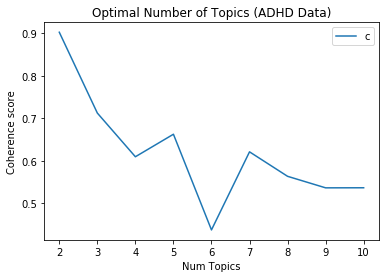

In [16]:
limit=11; start=2; 
x = range(start, limit)
plt.plot(x, coherence_values)
plt.title('Optimal Number of Topics (ADHD Data)')
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

### Once we have the weights and frequency of topic words, we are able to visualize the topics.

In [17]:
# visualize the topics
pyLDAvis.enable_notebook()
LDAvis_viz = pyLDAvis.gensim.prepare(best_model, corpus, dictionary)
LDAvis_viz

PreparedData(topic_coordinates=              x    y  topics  cluster       Freq
topic                                           
1      0.259335  0.0       1        1  52.530594
0     -0.259335  0.0       2        1  47.469406, topic_info=                                 Term         Freq        Total Category  \
term                                                                       
481                        meet_brain  4586.000000  4586.000000  Default   
132                              what  3857.000000  3857.000000  Default   
475                        have_heard  3061.000000  3061.000000  Default   
482               teamadhd_lifeinadhd  3057.000000  3057.000000  Default   
479                       learn_below  3057.000000  3057.000000  Default   
1050                      change_knew  3133.000000  3133.000000  Default   
64                              would  2297.000000  2297.000000  Default   
1051               exercise_nutrition  2090.000000  2090.000000  Default   
1049                  asking_question  2088.000000  2088.000000  Default   
1052                     find_started  2087.000000  2087.000000  Default   
1054                  important_sleep  2086.000000  2086.000000  Default   
478                             learn  1741.000000  1741.000000  Default   
12                      adhdawareness  1773.000000  1773.000000  Default   
183                             brain  1717.000000  1717.000000  Default   
32                               have  1602.000000  1602.000000  Default   
148                          teamadhd  1599.000000  1599.000000  Default   
477                             heard  1598.000000  1598.000000  Default   
480                              meet  1572.000000  1572.000000  Default   
230                           frontal  1536.000000  1536.000000  Default   
408                        lifeinadhd  1531.000000  1531.000000  Default   
483   teamadhd_lifeinadhd_learn_below  1528.000000  1528.000000  Default   
407                    frontal_vortex  1533.000000  1533.000000  Default   
410                            vortex  1531.000000  1531.000000  Default   
476         have_heard_frontal_vortex  1528.000000  1528.000000  Default   
474                             below  1537.000000  1537.000000  Default   
169                         important  1467.000000  1467.000000  Default   
210                          question  1343.000000  1343.000000  Default   
179                           started  1453.000000  1453.000000  Default   
435                              find  1379.000000  1379.000000  Default   
424                             sleep  1278.000000  1278.000000  Default   
...                               ...          ...          ...      ...   
1008                 treatment_option   237.102862   238.564654   Topic2   
1141     childhood_neurodevelopmental   234.073475   235.557330   Topic2   
1142                childhood_persist   234.073475   235.557330   Topic2   
1143                 disorder_prevent   234.073475   235.557330   Topic2   
1145                      growth_sign   234.073475   235.557330   Topic2   
1147                      often_begin   234.073475   235.557330   Topic2   
183                             brain  1704.223866  1717.450409   Topic2   
12                      adhdawareness  1755.205305  1773.598021   Topic2   
81                          childhood   257.009721   259.745933   Topic2   
916                            growth   122.707905   124.037225   Topic2   
1063                            begin   117.949654   119.241772   Topic2   
1140                  adulthood_learn   117.095858   118.470666   Topic2   
1144     disorder_prevent_growth_sign   117.095858   118.470666   Topic2   
1146                         hcpspace   117.095858   118.470666   Topic2   
960                         adulthood   125.380289   126.889899   Topic2   
623                              talk   174.659027   177.373610   Topic2   
335                        like_share

### We interpret the topics based on the keywords

In [26]:
print('1: Contact Awareness')
print('2: Treatment/Factors')

1: Contact Awareness
2: Treatment/Factors


### Finally, we label the data and save it.

In [33]:
cat_name = ['Contact/Awareness', 'Treatment/Factors']

def add_labels(model=best_model, corpus=corpus, data=data):
    # get main topic in each document
    topics = []
    categories = []
    for i, row in enumerate(model[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # dominant topic
                wp = model.show_topic(topic_num)
                topics.append(topic_num+1)
                categories.append(cat_name[topic_num])
            else:
                break
    data['category'] = categories
    data['class'] = topics
    return data.reset_index()

In [34]:
data_labelled = add_labels(model=best_model, corpus=corpus, data=data)

In [35]:
data_labelled.category.describe()

count                 10802
unique                    2
top       Contact/Awareness
freq                   7966
Name: category, dtype: object

In [36]:
data_labelled['class'].unique()

array([1, 2], dtype=int64)

In [37]:
data.head()

,user_ID,followers_count,user_location,user_description,date,text,hashtags,category,class
0,1.365320e+18,52,"Sheffield, England","❤Sal / UK\r\r\n🧡Player of games, Master of non...",10/27/2021 12:40,Saw GP today and we went through stuff and I t...,NaN,Contact/Awareness,1
1,5.363879e+07,1667,UK,27y/o nonbinary creator. They/Them. disabled. ...,10/27/2021 12:40,My ADHD Graveyard | Officially Diagnosed and A...,NaN,Treatment/Factors,2
2,1.329360e+18,12,"England, United Kingdom",38. A diagnosis referral is hard in the UK. Se...,10/27/2021 12:37,Have there been any studies of adults or child...,"['askADHD', 'ADHD']",Contact/Awareness,1
3,1.242600e+18,8,"West Hempstead, NY",OrganizeU4Life is making an impact on the live...,10/27/2021 12:35,Environmental factors don’t directly cause ADH...,NaN,Contact/Awareness,1
4,1.429030e+18,48,España,"🔞. Mainly NSFW. He/Him. 28. Gay, Single and Lo...",10/27/2021 12:33,Here in Spain we celebrate the national day of...,['ADHD'],Contact/Awareness,1


In [40]:
for i in range(3):
    random_tweet = random.randint(1,len(data))
    print('Tweet:', data.text[random_tweet])
    print('************************************************************')
    print('Category:', data.category[random_tweet])
    print('--------------------------------------------------------------------------------------------------------------------------------')





#ADHD_parents https://t.co/JerKIQvBT0
************************************************************
Category: Treatment/Factors
--------------------------------------------------------------------------------------------------------------------------------
Tweet: Professionals must include a ‘disclosure’ section in their assessments. There are pros and cons and it depends…on #context #autism #adhd #aspergers https://t.co/nmzlbjWB3z
************************************************************
Category: Contact/Awareness
--------------------------------------------------------------------------------------------------------------------------------



https://t.co/Rqene7HJRc
************************************************************
Category: Contact/Awareness
--------------------------------------------------------------------------------------------------------------------------------


In [41]:
data.to_csv('ADHD with TM labels.csv')